# Demonstrate the reproducibility of Zelinka and al. (2023) results


--- 

## What this notebook holds :

---

### Description of the notebook

This notebook aims at reproducing the results shown in *Zelinka and al.* (2023).
More details can be found in *sw_analysis_aprp_arctic.ipynb*.

### Article we are reproducing

Zelinka, M. D., Smith, C. J., Qin, Y., and Taylor, K. E.: Comparison of methods to estimate aerosol effective radiative forcings in climate models, Atmos. Chem. Phys., 23, 8879–8898, https://doi.org/10.5194/acp-23-8879-2023, 2023.

### APRP method's reference

Taylor, K. E., M. Crucifix, P. Braconnot, C. D. Hewitt, C. Doutriaux, A. J. Broccoli, J. F. B. Mitchell, and M. J. Webb, 2007: Estimating Shortwave Radiative Forcing and Response in Climate Models. J. Climate, 20, 2530–2543, https://doi.org/10.1175/JCLI4143.1. 

### APRP module used for our analysis' reference

https://doi.org/10.5281/zenodo.5514141

### Author

Giboni Lucas, 1st year PhD Candidate at IGE (CNRS), Grenoble.

https://github.com/gibonil/gibonil

### License

Feel free to share, use and improve the following code according to the provided license on the repository.

---

# Initialisation

---

## Importations

We import the needed libraries

In [26]:
# ================ IMPORTATIONS ================ #

### LOAD AND NAVIGATE THROUGH THE DATA ###

import os  # to get access to commands related to path setting and creation of directories

### DATA OBJECTS AND ASSOCIATED COMPUTATION ###

import numpy as np  # to handle numpy arrays and the associated tools

import xarray as xr  # to manage the data

import xcdat as xc  # to handle climate model outputs with xarray

### REPRESENTING DATA ###

import matplotlib.pyplot as plt # used for makings nice plots

import matplotlib.dates as mdates # used to show months in a plot legend

import matplotlib.colors as colors # used to linearly interpolate uneven colorbars

import matplotlib.path as mpath # used to handle the polar circle

from cartopy.util import add_cyclic_point # to have nice contours plot on the earth's map

### HOMEMADE LIBRARIES ###

## Load the climatology dictionary ##

from utilities.get_cmip6_data.store_data.dict_netcdf_transform import (
    netcdf_to_dict, # to load the climatology dictionary
)  

## Handle the climatology dictionary ##

from utilities.tools_for_analysis.handle_entries.extract_entries_names import (
    get_entries_only_from_clim_dict, # to add extract the entries' names
)

## Retrieve all the entries' names without the corresponding experiment ##

from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    add_one_variable_to_dataset, # to add one variable to the full dataset
)

## Generate a common grid on which we will regrid all CMIP6 outputs ##

from utilities.tools_for_analysis.regridding.regridding_methods import(
    generate_the_common_coarse_grid, # to create the common coarse grid 
    regridding_a_dictionary, # to regrid the aprp dictionary
)

## Extract only one variant's model output ##

from utilities.tools_for_analysis.handle_entries.extract_one_variant_per_model import (
    extract_only_one_variant_keys_list, # generates the keys' list with only one variant per source id
)

## Spatial avergaes ##

from utilities.tools_for_analysis.statistical_tools.spatial_average import (
    spatial_average_given_field, # to generate the spatial average of a given field for a dataset
    adapt_full_dict_for_spatial_average, # to make sure that the datasets are ready for spatial average
)

## Generate the table ##

from utilities.representing_data.generate_tables import (
   make_full_table, # to generate the table
)

### APRP LIBRARY ###

from utilities.aprp.code.aprp import(
    APRP, # APRP method
)

### Define the paths for saving and loading data

In this part, the user needs to define the paths at which will be downloaded the data and saved the climatologies if necessary. They also need to define the path to the table associating the monthly climatologies netcdf files with their respective key in the climatologies' dictionary to be loaded. These paths are the absolute paths from the home directory.

If *get_cmip6_data.ipynb* notebook was run before, then only the path to the *key_paths_table.pkl* file is relevant here.

In [27]:
# ================ DEFINE THE FOLDERS WHERE IS STORED THE DATA ================ #

### DEFINE THE HOME DIRECTORY ###

## Home directory ##

homedir_path = os.path.expanduser("~")

### DEFINE WHERE TO DOWNLOAD THE RAW DATA ###

## Parent directory of the download folder ##

parent_path_download = homedir_path + "/certainty-data"

## Name of the download folder ##

download_folder_name = "CMIP6-DATA"

### DEFINE WHERE TO SAVE THE CLIMATOLOGIES ###

## Path of the save directory ##

parent_path_save_clim = (
    homedir_path + "/certainty-data/" + download_folder_name + "/climatologies"
)

### DEFINE WHERE TO LOOK FOR THE TABLE OF THE CLIMATOLOGIES' PATHS ###

table_path = parent_path_save_clim + "/table" + "/key_paths_table.pkl"

## Load the CMIP6 climatology

We load the CMIP6 climatology. We first check the existence of the *key_paths_table.pkl* file that indicate that the *get_cmip6_data.ipynb* notebook was successfully run. Otherwise, we launch the full routine to download the raw data and generate the climatologies. 

**This full routine lasts about 2 hours if no download was done before.**

Sometimes the data cannot be found for the downloading phase even though the entry was found in the search phase... The user will need to relaunch the code as it is an error linked to the connection to the servers.

In [28]:
# ================ LOAD THE MONTHLY CLIMATOLOGIES ================ #

### CHECK IF THE CLIMATOLOGIES WERE GENERATED BEFORE ###

if os.path.lexists(path = table_path) :

    ## The table exists we can therefore load the dictionary of the climatologies ## 

    print("The monthly climatologies were generated and can be retrieved.")

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

else :

    ## The table does not exist : we need to download the data and prepare it ##

    print("No key_paths_table.pkl at the given path.\n" \
    "We download the data and create the monthly climatologies dictionary.")

    # We import the necessary submodule #

    from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    create_climatology_dict,  # to create the climatology dictionary and save it
    )

    ## Create the climatologies dictionary ##

    create_climatology_dict(
        data_path = parent_path_download,
        data_folder_name = download_folder_name,
        parent_path_for_save = parent_path_save_clim,
        selected_case = "ZELINKA-SW",
        do_we_clear = True,
        verbose = False,
    )

    ## Load it ##

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

The monthly climatologies were generated and can be retrieved.


## Apply the Approximate Partial Radiative Perturbation computation to our dictionary

### Generate the APRP dictionary

Before applying the APRP function we have to be able to call both the **control** and **aer** xarray datasets for a given entry. This is why we start by generating the list of the dictionary keys without the experiments.

In [29]:
# ================ GET THE KEYS WITHOUT THE EXPERIMENT REFERENCE ================ #

### GENERATE THE KEYS WITHOUT THE EXPERIMENT ###

## Copy the list of the keys of the clim dictionary ##

clim_keys = list(data_cmip6_clim.keys())

## Generate the unique list of keys without the reference to the experiments ##

clim_keys_without_exp = [
    get_entries_only_from_clim_dict(key_with_exp) for key_with_exp in clim_keys
]

We apply the APRP method.

In [30]:
dict_aprp = {}

for key in clim_keys_without_exp:

    key_control = key + ".piClim-control"

    key_aer = key + ".piClim-aer"

    data_cmip6_clim[key_control].load()

    data_cmip6_clim[key_aer].load()

    output = APRP(data_cmip6_clim[key_control], data_cmip6_clim[key_aer])

    dict_aprp[key] = output

---

## Regrid the dictionary entries on a common coarser grid

---

### Creating a common coarser grid for all CMIP6 outputs

In order to be able to compare the different results, we wish to project them on a common map. This map needs to be coarser than all the natives grid in order to not generate false signals but still needs to be close enough to their original resolution. The solution that was found here is to generate the coarsest grid steps for latitude and longitude from the ensemble and generate a regular grid from them.

In [31]:
common_coarse_grid = generate_the_common_coarse_grid(dict_aprp)

### Regrid the entries

We now proceed to the regridding of the full dictionary.

In [32]:
### FIELDS THAT WE REGRID ###

fields_to_be_regridded = [
    'cld',
    'sfc_alb',
    'sfc_alb_clr',
    'sfc_alb_oc',
    'noncld',
    'noncld_scat',
    'noncld_abs',
    'cld_amt',
    'cld_scat',
    'cld_abs'
    ]

### REGRIDDING ROUTINE ###

dict_aprp_regridded = regridding_a_dictionary(
    fields_to_be_regridded = fields_to_be_regridded,
    output_grid = common_coarse_grid,
    dictionary_to_be_regridded = dict_aprp
)

Initialize with one variable...



Regridding all the variables...: 100%|██████████| 9/9 [01:09<00:00,  7.69s/it]


Adding areacella...

Done !


---

## Time average of the monthly climatologies 

---

In order to display one common maps per varaible we average the twelve monthly climatology maps into one.

In [33]:
### COMPUTE TIME AVERAGE ###

## Generate a dictionary of the regridded APRP maps averaged over time ##

dict_aprp_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp[key].time.dt.month) # we already have monthly climatologies but this way we simplify the time coordinate into into a "month" coordinate
    .mean().mean("month") # average over time
    for key in list(dict_aprp.keys())
}

---

## Reproduce the table of Zelinka and al. (2023)

---

This part aims at reproducing the table found in the article for the shortwave. This table regroups the spatial average of different components of the aerosols' Shortwave Effective Radiative Forcing (SWERF) generated by the APRP method. 

Here is a screenshot of Table 2 found in *Zelinka and al. (2023)*.

<img src="/Users/lgiboni/Doctorat/code/CMIP6-Arctic-Aerosol-Analysis/img/zelinka-2023-table-screenshot.png">

We generate our own table from the provided time averaged dictionary. It is worth mentioning that the model **GFDL-ESM4.r1i1p1f1** could not be downloaded and won't be shown in our table.

In [34]:
full_table = make_full_table(dataset_dictionary = dict_aprp_time_avg)

We extract the mean and the std for every column of the table. They are rounded to two decimals.

In [35]:
### MEAN ###

mean = full_table.mean(skipna = True).round(2)

### STD ###

std = full_table.std(skipna = True).round(2)

We display our own table showing some small differences but only to the second decimal.

In [36]:
full_table

ARI               ACI                      \
                               scat   abs   sum  scat   abs cld_amt   sum   
ACCESS-CM2.r1i1p1f1.gn        -0.84  0.42 -0.42 -0.82 -0.01   -0.13 -0.96   
ACCESS-ESM1-5.r1i1p1f1.gn     -0.44  0.28 -0.16 -1.04  0.05   -0.13 -1.12   
BCC-ESM1.r1i1p1f1.gn          -1.13  0.30 -0.83 -0.62 -0.09   -0.09 -0.80   
CESM2.r1i1p1f1.gn             -0.26  0.50  0.24 -1.80  0.04   -0.00 -1.76   
CNRM-CM6-1.r1i1p1f2.gr        -0.65  0.29 -0.36 -0.83 -0.07    0.05 -0.85   
CNRM-ESM2-1.r1i1p1f2.gr       -0.44  0.25 -0.19 -0.54 -0.06   -0.03 -0.63   
CanESM5.r1i1p2f1.gn           -0.64  0.76  0.12 -0.92  0.08   -0.14 -0.98   
GFDL-CM4.r1i1p1f1.gr1         -0.68  0.59 -0.09 -0.55  0.00   -0.09 -0.64   
GISS-E2-1-G.r1i1p1f1.gn       -0.94  0.27 -0.67  0.07  0.02   -0.95 -0.86   
GISS-E2-1-G.r1i1p1f2.gn       -0.88  0.20 -0.68  0.08  0.03   -0.84 -0.73   
GISS-E2-1-G.r1i1p3f1.gn       -0.99  0.24 -0.75 -0.23 -0.01   -0.07 -0.31   
HadGEM3-GC31-LL.r1i1p1f3.gn   -0.83  0.42 -0.41 -0.78 -0.01   -0.07 -0.86   
IPSL-CM6A-LR-INCA.r1i1p1f1.gr -0.69  0.20 -0.49 -0.29 -0.01    0.03 -0.27   
IPSL-CM6A-LR.r1i1p1f1.gr      -0.63  0.23 -0.40 -0.28 -0.01    0.09 -0.20   
IPSL-CM6A-LR.r2i1p1f1.gr      -0.63  0.23 -0.40 -0.29 -0.01    0.01 -0.29   
IPSL-CM6A-LR.r3i1p1f1.gr      -0.63  0.24 -0.39 -0.25 -0.02    0.11 -0.16   
IPSL-CM6A-LR.r4i1p1f1.gr      -0.63  0.23 -0.40 -0.29 -0.01    0.02 -0.28   
MIROC6.r11i1p1f1.gn           -0.47  0.12 -0.35 -1.13 -0.09   -0.03 -1.25   
MIROC6.r1i1p1f1.gn            -0.48  0.13 -0.35 -1.13 -0.08   -0.01 -1.22   
MPI-ESM-1-2-HAM.r1i1p1f1.gn   -0.26  0.27  0.01 -1.35  0.03   -0.24 -1.56   
MRI-ESM2-0.r1i1p1f1.gn        -0.76  0.27 -0.49 -1.73 -0.12   -0.38 -2.23   
NorESM2-LM.r1i1p1f1.gn        -0.43  0.30 -0.13 -1.16 -0.00   -0.10 -1.26   
NorESM2-LM.r1i1p2f1.gn        -0.45  0.31 -0.14 -1.32  0.01   -0.19 -1.50   
NorESM2-MM.r1i1p1f1.gn        -0.42  0.32 -0.10 -1.19  0.02   -0.17 -1.34   
UKESM1-0-LL.r1i1p1f4.gn       -0.76  0.48 -0.28 -0.85 -0.01   -0.10 -0.96   

                                          
                              ACI + ARI   
ACCESS-CM2.r1i1p1f1.gn             -1.38  
ACCESS-ESM1-5.r1i1p1f1.gn          -1.28  
BCC-ESM1.r1i1p1f1.gn               -1.63  
CESM2.r1i1p1f1.gn                  -1.52  
CNRM-CM6-1.r1i1p1f2.gr             -1.21  
CNRM-ESM2-1.r1i1p1f2.gr            -0.82  
CanESM5.r1i1p2f1.gn                -0.86  
GFDL-CM4.r1i1p1f1.gr1              -0.73  
GISS-E2-1-G.r1i1p1f1.gn            -1.53  
GISS-E2-1-G.r1i1p1f2.gn            -1.41  
GISS-E2-1-G.r1i1p3f1.gn            -1.06  
HadGEM3-GC31-LL.r1i1p1f3.gn        -1.27  
IPSL-CM6A-LR-INCA.r1i1p1f1.gr      -0.76  
IPSL-CM6A-LR.r1i1p1f1.gr           -0.60  
IPSL-CM6A-LR.r2i1p1f1.gr           -0.69  
IPSL-CM6A-LR.r3i1p1f1.gr           -0.55  
IPSL-CM6A-LR.r4i1p1f1.gr           -0.68  
MIROC6.r11i1p1f1.gn                -1.60  
MIROC6.r1i1p1f1.gn                 -1.57  
MPI-ESM-1-2-HAM.r1i1p1f1.gn        -1.55  
MRI-ESM2-0.r1i1p1f1.gn             -2.72  
NorESM2-LM.r1i1p1f1.gn             -1.39  
NorESM2-LM.r1i1p2f1.gn             -1.64  
NorESM2-MM.r1i1p1f1.gn             -1.44  
UKESM1-0-LL.r1i1p1f4.gn            -1.24

We display the mean per column :

In [37]:
mean

ARI  scat         -0.64
     abs           0.31
     sum          -0.32
ACI  scat         -0.77
     abs          -0.01
     cld_amt      -0.14
     sum          -0.92
     ACI + ARI    -1.25
dtype: float64

We display the std per column :

In [38]:
std

ARI  scat          0.22
     abs           0.14
     sum           0.26
ACI  scat          0.51
     abs           0.05
     cld_amt       0.25
     sum           0.53
     ACI + ARI     0.48
dtype: float64

--- 

## Reproduce Zelinka's maps

---

This part aims at reproducing the maps found in the article for the shortwave. Here is a screenshot of these maps :

<img src="/Users/lgiboni/Doctorat/code/CMIP6-Arctic-Aerosol-Analysis/img/zelinkas-map.png">

We first define a function that will be used to generate a list that contains, for every entry, the list of the four spatial averages of the variables shown on the map. 

In [39]:
def create_list_of_spatial_averaged_variables_for_given_entry(dataset : xr.Dataset) -> list[float]:

    plot_list_avg = [
    (dataset.spatial.average("cld", axis=["X", "Y"])["cld"] + dataset.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI + ACI
    (dataset.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI
    (dataset.spatial.average("cld", axis=["X", "Y"])["cld"]).values, # SW ERF ACI
    (dataset.spatial.average("sfc_alb", axis=["X", "Y"])["sfc_alb"]).values, # DELTA ALBED SURF
    ]

    return plot_list_avg


We define the list of the models that were used to generate the maps in *Zelinka and al. (2023)*. These are the models with a '*' in the screenshot of Table 2. As mentioned previously, the model **GFDL-ESM4.r1i1p1f1** could not be downloaded and won't be used here. Still, we will add its values found in the article to our list of averaged variables in order to reproduce faithfully the values shown on the screenshot of the maps.

In [40]:
reduced_list = [
'CNRM-CM6-1.r1i1p1f2.gr',
'CNRM-ESM2-1.r1i1p1f2.gr',
'CanESM5.r1i1p2f1.gn',
'GFDL-CM4.r1i1p1f1.gr1',
'MPI-ESM-1-2-HAM.r1i1p1f1.gn',
'MRI-ESM2-0.r1i1p1f1.gn',
'NorESM2-LM.r1i1p1f1.gn',
'NorESM2-LM.r1i1p2f1.gn',
'NorESM2-MM.r1i1p1f1.gn',
'UKESM1-0-LL.r1i1p1f4.gn'
 ]

We generate the reduced regridded and time averaged dictionary.

In [41]:
dict_aprp_reduced = {
    key : dict_aprp_time_avg[key]
    for key in reduced_list
}

After that, we are able to make the list of averaged variables for every remaining entry. We add the values for GFDL-ESM4.r1i1p1f1.

In [42]:
### MAKE THE FULL LIST OF AVERAGED VARIABLES FOR THE MAPS ###

## Producing the list of averaged variables to display on the maps ##

list_avgd_variables_for_all_entries = [
    create_list_of_spatial_averaged_variables_for_given_entry(dict_aprp_reduced[key])
    for key in dict_aprp_reduced.keys()
]

## Adding GFDL-ESM4 (missing) thanks to the article's results ##

list_avgd_variables_for_all_entries.append([-0.55, +0.09, -0.64, np.nan])

## Rounding the results to two decimals ##

res_to_show = np.round(np.nanmean(list_avgd_variables_for_all_entries, axis = 0), 2)

Then, we compute the average maps by averaging the different entries' maps.

In [43]:
### MAKING THE ENTRY AVERAGES TO GENERATE A MEAN MAP ###

ensemble_aprp_avg = xr.concat(dict_aprp_reduced.values(), "entry").mean(
    dim="entry"
)

Finally, we show the maps thanks to the following plotting routine.


''

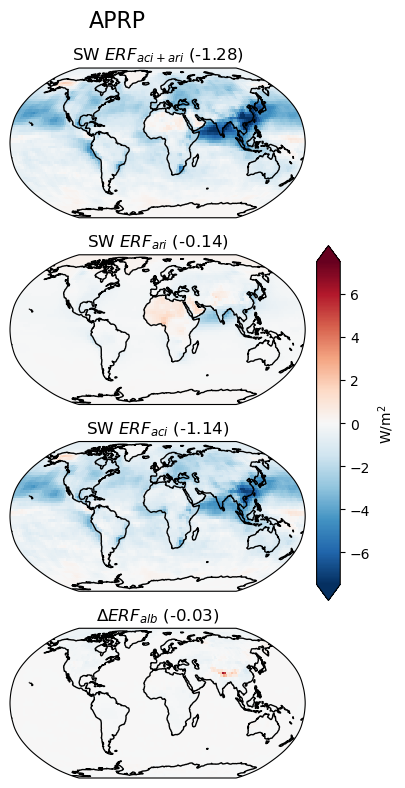

In [ ]:
output = ensemble_aprp_avg

fig = plt.figure(figsize = (6,8))
plt.suptitle("APRP", fontsize=16)
axes = fig.subplots(nrows= 4, ncols = 1, subplot_kw={"projection": ccrs.Robinson()})
cnt = -1

avgmap = output

plot_list_avg = res_to_show

plot_list_map = [
    (avgmap["cld"] + avgmap["noncld"]), # SW ERF ARI + ACI
    (avgmap["noncld"]), # SW ERF ARI
    (avgmap["cld"]), # SW ERF ACI
    (avgmap["sfc_alb"]), # DELTA ALBED SURF
]

list_titles = [
        "SW $ERF_{aci + ari}$",
        "SW $ERF_{ari}$",
        "SW $ERF_{aci}$",
        "$\\Delta ERF_{alb}$"
]
for row in range(4):
        
        cnt += 1

        avg = plot_list_avg[cnt]

        pl = plot_list_map[cnt].plot(
            ax=axes[row],
            transform=ccrs.PlateCarree(),
            vmin=-7.5,
            vmax=7.5,
            cmap="RdBu_r",
            add_colorbar=False,
        )
        axes[row].set_title(list_titles[cnt] + " (" + str(avg) + ")")

        axes[row].coastlines()

plt.tight_layout()

fig.colorbar(
    pl, ax=axes.ravel().tolist(), pad=0.02, shrink=0.5, aspect=15, label="W/m$^2$", extend='both'
)

The maps seem to perfectly maps the maps of the article. Still, the mean values for ACI and ACI+ARI are different to the second decimal. We assume that this difference is not tied to a method implementation error but to some discrepancies in the rounding of the different variables.